In [ ]:
import torch
import torchvision.transforms as tr # 이미지 전처리 기능들을 제공하는 라이브러리
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
import torch.nn.functional as F

import numpy as np # 넘파이 기본 라이브러리
import matplotlib.pyplot as plt #시각화
from sklearn.metrics import confusion_matrix # confusion matrix그리기용
import pandas as pd
import itertools
import os


In [ ]:
torch.manual_seed(1) #  random seed를 고정

In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
default_path= '/content/gdrive/MyDrive/22.1/인공신경망과딥러닝/HW/UCI HAR Dataset/UCI HAR Dataset/'

### Data Load


Data 전처리 코드  


In [ ]:
# reference : https://github.com/nicolas-chaulet/human-activity-recognition/blob/master/src/dataset/ucihar.py
class UCIHAR(torch.utils.data.Dataset):
    def __init__(self,raw_dir, split='train', channel_first=True):
        self._raw_dir = raw_dir
        self._split = split
        self._record_folder = os.path.join(self._raw_dir,split)


        
        self.X, self.y = self.load_dataset_group()
        if channel_first:
            self.X = self.X.transpose(2,1) #[B, C, T] time is the last dimension in pytorch
            self._n_timesteps = self.X.shape[-1]
            self._n_features = self.X.shape[1]
        else:
            self._n_timesteps = self.X.shape[1]
            self._n_features = self.X.shape[-1]
        self.y -= 1 # Labels start at 0
        self.y = self.y.squeeze(-1)
        print(self.y.shape)
        print(self.X.shape)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    @property
    def n_timesteps(self):
       return self._n_timesteps

    @property
    def n_features(self):
        return self._n_features

    @property
    def n_labels(self):
        return torch.max(self.y).item() + 1

    # load a single file as a numpy array
    @staticmethod
    def load_file(filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values
    
    # load a list of files and return as a 3d numpy array
    @staticmethod
    def load_X(filenames, prefix = ""):
        loaded = list()
        for name in filenames:
            data = UCIHAR.load_file(os.path.join(prefix,name))
            loaded.append(data)
        # stack group so that features are the 3rd dimension
        loaded = np.dstack(loaded)
        return loaded

    def load_dataset_group(self):
        filepath = os.path.join(self._record_folder,'Inertial Signals/')
        # load all 9 files as a single array
        filenames = list()
        # total acceleration
        filenames += ['total_acc_x_'+self._split+'.txt', 'total_acc_y_'+self._split+'.txt', 'total_acc_z_'+self._split+'.txt']
        # body acceleration
        filenames += ['body_acc_x_'+self._split+'.txt', 'body_acc_y_'+self._split+'.txt', 'body_acc_z_'+self._split+'.txt']
        # body gyroscope
        filenames += ['body_gyro_x_'+self._split+'.txt', 'body_gyro_y_'+self._split+'.txt', 'body_gyro_z_'+self._split+'.txt']
        # load input data
        X = UCIHAR.load_X(filenames, filepath)
        # load class output
        y = UCIHAR.load_file(os.path.join(self._record_folder, 'y_'+self._split+'.txt'))
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long)

In [ ]:
train_dataset = UCIHAR(default_path, split='train')
test_dataset = UCIHAR(default_path, split='test')  

print("Size of train dataset = %i" % len(train_dataset))
print("Size of test dataset = %i" % len(test_dataset))

torch.Size([7352])
torch.Size([7352, 9, 128])
torch.Size([2947])
torch.Size([2947, 9, 128])
Size of train dataset = 7352
Size of test dataset = 2947


In [ ]:
# 기본 변수
n_features = train_dataset.n_features
n_timesteps = train_dataset.n_timesteps
n_labels = train_dataset.n_labels
print("Size of features = %i" % n_features )
print("Size of timesteps = %i" % n_timesteps)
print("Size of labels = %i" % n_labels)

# 학습 파라미터
batch_size = 64
learning_rate = 1e-3
training_epochs = 30
    
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Size of features = 9
Size of timesteps = 128
Size of labels = 6


### Model definition
#### CNN1D

In [ ]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.layer=  nn.Sequential(
            nn.Conv1d(in_channels = n_features, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(3),
            nn.Flatten(),
            nn.Linear(in_features=42*64, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=n_labels)           
        )

    
    def forward(self, x):
        output = self.layer(x)
        return output

In [ ]:
conv1d = CNN1D().to(device)
print(conv1d)

CNN1D(
  (layer): Sequential(
    (0): Conv1d(9, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=2688, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=6, bias=True)
  )
)


#### LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.layer1 = nn.LSTM(input_size=n_features, hidden_size=64, num_layers=3, batch_first=True)
        self.layer2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.MaxPool1d(3),
            nn.Flatten(),
            nn.Linear(in_features=42*64, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=n_labels))
      
    def forward(self, x):
        output = self.layer1(x)[0]
        output = self.layer2(output)
       
        return output


In [ ]:
lstm = LSTM().to(device)
print(lstm)

LSTM(
  (layer1): LSTM(9, 64, num_layers=3, batch_first=True)
  (layer2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=2688, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=6, bias=True)
  )
)


### Model Train
#### CNN

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer_1 = optim.Adam(conv1d.parameters(), lr=learning_rate) # optimizer 정의

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer_1 = optim.Adam(conv1d.parameters(), lr=learning_rate) # optimizer 정의

loss_1 = [] # 그래프를 그리기 위한 loss 저장용 리스트
acc_1 = [] # 그래프를 그리기 위한 accuracy 저장용 리스트
n = len(train_loader)

for epoch in range(training_epochs): 
    correct, total, total_loss_1 = 0, 0, 0
    
    for sample, label in train_loader:
        sample, label = sample.to(device).float(), label.to(device).long()
        
        optimizer_1.zero_grad()# 초기화
        
        output = conv1d(sample) # 모델에서 훈련
        loss = criterion(output, label) # 오차 계산
        
        loss.backward() # 역전파
        optimizer_1.step() # 스텝(파라미터 업데이트)
        
        total_loss_1 += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum()
    acc_train_1 = float(correct)/ len(train_loader.dataset)
    
    loss_1.append(total_loss_1/n)
    acc_1.append(acc_train_1)
    
  
    print("Epoch: {}/{} ".format(epoch+1, training_epochs),
                  "Loss: {:.4f} ".format(total_loss_1/n),

                  "Accuracy: {:.4f}".format(acc_train_1))


Epoch: 1/30  Loss: 0.8875  Accuracy: 0.6559
Epoch: 2/30  Loss: 0.5241  Accuracy: 0.7711
Epoch: 3/30  Loss: 0.4355  Accuracy: 0.8203
Epoch: 4/30  Loss: 0.3615  Accuracy: 0.8569
Epoch: 5/30  Loss: 0.3069  Accuracy: 0.8842
Epoch: 6/30  Loss: 0.2781  Accuracy: 0.8959
Epoch: 7/30  Loss: 0.2524  Accuracy: 0.9061
Epoch: 8/30  Loss: 0.2271  Accuracy: 0.9153
Epoch: 9/30  Loss: 0.1932  Accuracy: 0.9339
Epoch: 10/30  Loss: 0.1669  Accuracy: 0.9392
Epoch: 11/30  Loss: 0.1506  Accuracy: 0.9434
Epoch: 12/30  Loss: 0.1364  Accuracy: 0.9498
Epoch: 13/30  Loss: 0.1315  Accuracy: 0.9516
Epoch: 14/30  Loss: 0.1290  Accuracy: 0.9514
Epoch: 15/30  Loss: 0.1571  Accuracy: 0.9419
Epoch: 16/30  Loss: 0.1806  Accuracy: 0.9358
Epoch: 17/30  Loss: 0.1244  Accuracy: 0.9521
Epoch: 18/30  Loss: 0.1201  Accuracy: 0.9520
Epoch: 19/30  Loss: 0.1182  Accuracy: 0.9529
Epoch: 20/30  Loss: 0.1176  Accuracy: 0.9533
Epoch: 21/30  Loss: 0.1155  Accuracy: 0.9516
Epoch: 22/30  Loss: 0.1147  Accuracy: 0.9527
Epoch: 23/30  Loss:

#### LSTM

In [ ]:
criterion = nn.CrossEntropyLoss().to(device) # loss function 정의
optimizer_2 = optim.Adam(lstm.parameters(), lr=learning_rate) # optimizer 정의

In [ ]:
loss_2 = [] # 그래프를 그리기 위한 loss 저장용 리스트
acc_2 = [] # 그래프를 그리기 위한 accuracy 저장용 리스트
n = len(train_loader)

for epoch in range(training_epochs): 
    correct, total, total_loss_2 = 0, 0, 0
    
    for sample, label in train_loader:
        sample, label = sample.to(device).transpose(2,1).float(), label.to(device).long()
        
        optimizer_2.zero_grad()# 초기화
        
        output = lstm(sample) # 모델에서 훈련
        loss = criterion(output, label) # 오차 계산
        
        loss.backward() # 역전파
        optimizer_2.step() # 스텝(파라미터 업데이트)
        
        total_loss_2 += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum()
    acc_train_2 = float(correct) / len(train_loader.dataset)
    
    loss_2.append(total_loss_2/n)
    acc_2.append(acc_train_2)
    
    print("Epoch: {}/{} ".format(epoch+1, training_epochs),
                "Loss: {:.4f} ".format(total_loss_2/n),

                "Accuracy: {:.4f}".format(acc_train_2))



Epoch: 1/30  Loss: 1.5031  Accuracy: 0.3594
Epoch: 2/30  Loss: 1.3111  Accuracy: 0.3977
Epoch: 3/30  Loss: 1.1100  Accuracy: 0.5019
Epoch: 4/30  Loss: 0.7550  Accuracy: 0.6790
Epoch: 5/30  Loss: 0.6652  Accuracy: 0.6961
Epoch: 6/30  Loss: 0.4757  Accuracy: 0.7894
Epoch: 7/30  Loss: 0.3693  Accuracy: 0.8444
Epoch: 8/30  Loss: 0.3699  Accuracy: 0.8565
Epoch: 9/30  Loss: 0.3287  Accuracy: 0.8761
Epoch: 10/30  Loss: 0.2962  Accuracy: 0.8901
Epoch: 11/30  Loss: 0.2362  Accuracy: 0.9136
Epoch: 12/30  Loss: 0.2134  Accuracy: 0.9208
Epoch: 13/30  Loss: 0.1964  Accuracy: 0.9313
Epoch: 14/30  Loss: 0.2575  Accuracy: 0.9120
Epoch: 15/30  Loss: 0.1957  Accuracy: 0.9376
Epoch: 16/30  Loss: 0.1704  Accuracy: 0.9362
Epoch: 17/30  Loss: 0.1668  Accuracy: 0.9416
Epoch: 18/30  Loss: 0.1597  Accuracy: 0.9387
Epoch: 19/30  Loss: 0.2165  Accuracy: 0.9263
Epoch: 20/30  Loss: 0.1680  Accuracy: 0.9369
Epoch: 21/30  Loss: 0.1505  Accuracy: 0.9444
Epoch: 22/30  Loss: 0.1599  Accuracy: 0.9397
Epoch: 23/30  Loss:

### Model Test
#### CNN

In [ ]:
pred_1 = []
t_acc_1 = []

total, correct = 0, 0

with torch.no_grad():
    conv1d.eval()
    for sample, label in test_loader:
        sample, label = sample.to(device).float(), label.to(device).long()
        
        output = conv1d(sample)
        
        _, predicted = torch.max(output.data, 1)
        total += label.size(0) 
        correct += (predicted == label).sum().item()
        accuracy = correct / total
        
        pred_1.append(predicted)
        t_acc_1.append(accuracy)

mean_accuracy_1 = np.mean(t_acc_1)

# 정확도 출력
print('Test Accuracy: ', round(mean_accuracy_1,4))


Test Accuracy:  0.8678


#### LSTM

In [ ]:
pred_2 = []
t_acc_2 = []

total, correct = 0, 0

with torch.no_grad():
    lstm.eval()
    for sample, label in test_loader:
        sample, label = sample.to(device).transpose(2,1).float(), label.to(device).long()
        
        output = lstm(sample)
        
        _, predicted = torch.max(output.data, 1)
        total += label.size(0) 
        correct += (predicted == label).sum().item()
        accuracy = correct / total
        
        pred_2.append(predicted)
        t_acc_2.append(accuracy)

mean_accuracy_2 = np.mean(t_acc_2)

# 정확도 출력
print('Test Accuracy: ', round(mean_accuracy_2,4))

Test Accuracy:  0.7889


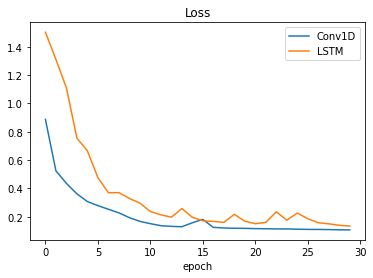

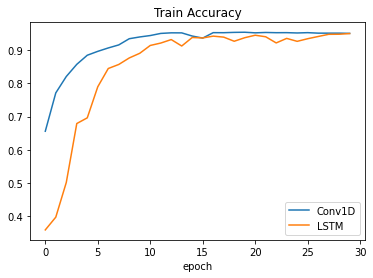

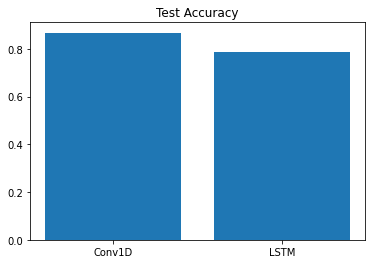

In [ ]:
# Plotting
plt.plot(loss_1,label='Conv1D')
plt.plot(loss_2,label='LSTM')
plt.xlabel("epoch")
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(acc_1,label='Conv1D')
plt.plot(acc_2,label='LSTM')
plt.xlabel("epoch")
plt.legend()
plt.title('Train Accuracy')
plt.show()

plt.bar(np.arange(2),[mean_accuracy_1,mean_accuracy_2])
plt.xticks(np.arange(2),['Conv1D','LSTM'])
plt.title('Test Accuracy')
plt.show()


### Confusion Matrix 그리기

In [ ]:
# https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)
    figure = plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def cm(pred_,model_name):
    classes = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
    c_predict = []
    for _ in range(len(pred_)):
        for xx in pred_[_].tolist():
            c_predict.append(xx)
    cm=confusion_matrix(test_dataset.y.tolist(),c_predict)
    plot_confusion_matrix(cm,classes ,normalize=True,title= model_name+' Confusion matrix')

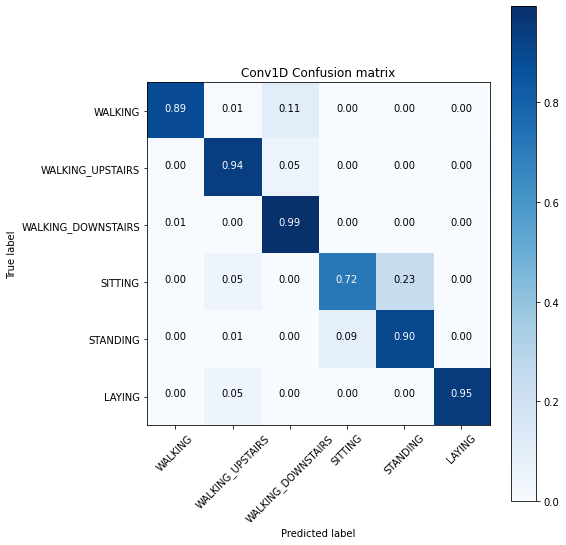

In [24]:
cm(pred_1,'Conv1D')

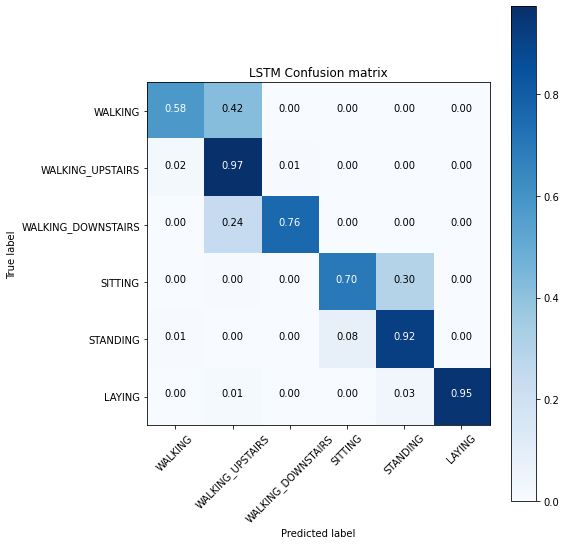

In [ ]:
cm(pred_2,'LSTM')